# Exercises 3.

*Antti Härkönen*

## 1.

$$ q_j*(z_j) \propto exp(E_{-j}[log p(z_j, \bf z_{-j}, \bf x)]) $$

$$ = exp[E_{-j}(log [p(z_j \mid \bf z_{-j}, \bf x) \prod_{i \neq j}p(z_i \mid \bf x) \prod_j p(\bf x_j)])] $$

$$ = exp[E_{-j}(log [p(z_j \mid z_{-j}, x)] + \sum_{i \neq j} E_{i}log [p(z_i \mid x)] + \sum_j E_{j}log [p(\bf x_j)])] $$

$$ = exp(E_{-j}[log p(z_j \mid z_{-j}, x)]) \prod_{i \neq j} exp(E_{i}log [p(z_i \mid x)]) \prod_j exp [E_{j}log p(\bf x_j)] $$

$$ = exp(E_{-j}[log p(z_j \mid z_{-j}, x)]) \prod_{i \neq j} exp(const.) \prod_j exp (const.) $$

$$ \propto exp(E_{-j}[log p(z_j \mid \bf z_{-j}, \bf x)])$$

$$ \square $$

## 2.

$$ q(\mu, \bf \Lambda, \pi) = q(\mu \mid \Lambda, \pi) q(\Lambda \mid \pi) q(\pi) $$

$$ = q(\pi) \prod^K_{k=1} q(\mu_k \mid \Lambda_k, \pi) \prod^K_{k=1} q(\Lambda_k \mid \pi) $$

$$ = q(\pi) \prod^K_{k=1} \frac{q(\mu_k, \Lambda_k, \pi)}{q(\Lambda_k, \pi)} \times \frac{q(\Lambda_k, \pi)}{q(\pi)} $$

$$ = q(\pi) \prod^K_{k=1} \frac{q(\mu_k, \Lambda_k, \pi)}{q(\pi)} $$

There are no paths from $\pi$ to $\mu$ or $\Lambda$, so they are independent and
$q(\mu_k, \Lambda_k, \pi) = q(\mu_k, \Lambda_k) q(\pi)$.

$$ = q(\pi) \prod^K_{k=1} \frac{q(\mu_k, \Lambda_k) q(\pi)}{q(\pi)} $$

$$ = q(\pi) \prod^K_{k=1}q(\mu_k, \Lambda_k) $$

$$ \square $$

## 3.

In [4]:
import json
from typing import Iterable

import numpy as np
import pandas as pd
import networkx as nx
from scipy.special import psi

edges = pd.read_csv('email-Eu-core.txt', sep=' ')
labels = pd.read_csv('email-Eu-core-department-labels.txt', sep=' ')
selection = set(labels.loc[labels['1'] <= 10, '0'])
labels = labels[labels['0'].isin(selection)].reset_index()
y = nx.to_numpy_matrix(nx.from_pandas_edgelist(labels, '0', '1'))

class MMSBModel:
    def __init__(self, y, k, alpha):
        self.N = self.M = y.shape[0]
        self.K = k
        self.alpha = np.repeat(alpha, self.K).astype(np.float16)
        self.Y = y.astype(np.float16)
        self.phi = np.random.dirichlet(self.alpha, size=(self.N, self.M)).astype(np.float16)
        self.gamma = np.random.dirichlet(np.ones(self.K), size=self.N).astype(np.float16)
        self.B = np.random.random(size=(self.K, self.K)).astype(np.float16)

    def vi(self, convergence_threshold=0.01, max_iter=1000):
        Y = np.array(self.Y, copy=True)[..., np.newaxis, np.newaxis]
        Y_T = Y.transpose(1, 0, 2, 3)
        for it in range(max_iter):
            phi = np.broadcast_to(self.phi[..., np.newaxis], (self.N, self.M, self.K, self.K)).copy()
            phi[np.arange(self.N), np.arange(self.M)] = np.zeros((self.K, self.K))
            possible_connections = np.transpose(phi, axes=(1, 0, 3, 2)) * phi
            B_new = (possible_connections * np.broadcast_to(
                        self.Y[..., np.newaxis, np.newaxis],
                        possible_connections.shape)
                    ).sum(axis=(0, 1), keepdims=True) / possible_connections.sum(axis=(0, 1), keepdims=True)

            for _ in range(max_iter):
                phi = self.phi.copy()[..., np.newaxis].transpose(1,0,2,3)
                mean_log_pi = np.exp(psi(self.gamma) - psi(self.gamma.sum(axis=1, keepdims=True)))
                mean_log_pi = np.broadcast_to(
                    np.expand_dims(mean_log_pi, axis=1),
                    (self.N, self.M, self.K),
                ).copy()
                phi = mean_log_pi * np.prod(((B_new**Y) * ((1. - B_new)**(1. - Y)))**phi, axis=3)
                phi_new = phi / phi.sum(axis=2, keepdims=True)
                self.phi = phi_new.copy()

                phi = self.phi.copy()[..., np.newaxis]
                B_T = B_new.transpose(0, 1, 3, 2)
                phi = mean_log_pi * np.prod(((B_T**Y_T) * ((1. - B_T)**(1. - Y_T)))**phi, axis=2)
                phi_new = phi / phi.sum(axis=2, keepdims=True)
                self.phi = phi_new.copy()
                gamma_new = self.alpha + self.phi.sum(axis=0) + self.phi.sum(axis=1)

                change_gamma = np.abs(gamma_new - self.gamma).sum()
                self.gamma = gamma_new
                if change_gamma <= convergence_threshold:
                    break
            B_new = np.squeeze(B_new)
            change_B = np.abs((B_new - self.B)).sum()
            self.B = B_new
            if change_B <= convergence_threshold:
                print(f"VI finished with {it} iterations.")
                break
        else:
            print(f"VI finished with {max_iter} iterations.")

model = MMSBModel(y, 10, 0.1)
model.vi(max_iter=100, convergence_threshold=0.001)
gamma = pd.DataFrame(model.gamma, columns=[i for i in range(1, 11)])
gamma.to_csv('gamma.csv')

VI finished with 31 iterations.


            1         2         3         4         5          6         7  \
0    0.100002  0.100002  0.100002  0.100002  0.100002  624.95580  0.100002   
20   0.100005  0.100005  0.100005  0.100005  0.100005  810.61280  0.100005   
40   0.100005  0.100005  0.100005  0.100005  0.100005  810.19040  0.100005   
60   0.100005  0.100005  0.100005  0.100005  0.100005  810.35170  0.100005   
80   0.100005  0.100005  0.100005  0.100005  0.100005  810.61280  0.100005   
100  0.100005  0.100005  0.100005  0.100005  0.100005  810.42004  0.100005   
120  0.100005  0.100005  0.100005  0.100005  0.100005  810.61280  0.100005   
140  0.100005  0.100005  0.100005  0.100005  0.100005  810.42004  0.100005   
160  0.100005  0.100005  0.100005  0.100005  0.100005  810.35170  0.100005   
180  0.100005  0.100005  0.100005  0.100005  0.100005  810.36070  0.100005   
200  0.100005  0.100005  0.100005  0.100005  0.100005  810.61280  0.100005   
220  0.100005  0.100005  0.100005  0.100005  0.100005  810.24350

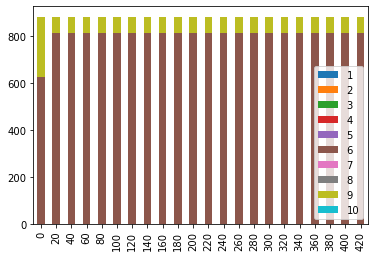

In [11]:
import pandas as pd

gamma = pd.read_csv('gamma.csv', index_col=0)[::20]
gamma.plot.bar(stacked=True)
print(gamma)

I tested the model on the members of the first 10 groups.

## 4.